# Model Building: Pitchers

### Overview: 
            - Load Libraries and csvs created from earlier notebooks
            - Data filtering to include players HOF eligible.
            - Exploratory Analysis
            - Train Model
            - Use oversampling on minority class
            - Feature Selection 
            

In [1]:
import pandas as pd
import numpy as np 
from plotnine import *
import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

dfP = pd.read_csv('~/jupyter/cs2019_Group4/GroupProducts/dfP')

Remove rows with 'infinity' values and fill null values with 0s (these come from calculations that involve players with not many values in specific columns / don't reach a minimum # of records for statistical significance)

In [2]:
#drop rows with infinity values
dfP = dfP.replace([np.inf, -np.inf], np.nan)
#fill NaNs with 0
dfP = dfP.fillna(0)

## Train and Test sets:
The next step is to subset our dataframe to show only those individuals who are Hall of Fame eligible. Active players will throw off the model, so we are removing these players. The HOFeligible variable is removed so the correlaion matrix will be informative. 

The next step is to create train and test sets. The training set will be used to train the model and have the alogrithm learn on the data to help make predictions. The test dataset is a dataset used to provide an unbiased evaluation of a final model fit on the training dataset.We get rid of the playerID and fullName field because these variables cannot be used in prediction

In [3]:
#Defining variables, train and test sets 
feature_cols = dfP.drop(['inducted'], axis = 1).columns
X = dfP.loc[dfP.HOFeligible ==1, feature_cols]
y = dfP.loc[dfP.HOFeligible ==1, 'inducted']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=0)


#get rid of text columns as this will ruin the model
X_train = X_train.drop(['playerID', 'fullName'], axis=1)
X_test = X_test.drop(['playerID', 'fullName'], axis=1)

## Oversampling on the datasets:
We need to deal with our imbalanced dfs by oversampling (creating an a 50/50 split of HoF inductees and non-inductees) this will improve our model. Oversampling can be a good choice when you don’t have a ton of data to work with. After resampling we have an equal ratio of data points for each class

In [4]:
# Oversampling technique:

from sklearn.utils import resample

# # Separate input features and target
# y = dfO.inducted 
# X = dfO.drop('inducted', axis=1)

# # setting up testing and training sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_HoF = X[X.inducted==0]
HoF = X[X.inducted==1]

# upsample minority
HoF_upsampled = resample(HoF,
                          replace=True, # sample with replacement
                          n_samples=len(not_HoF), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_HoF, HoF_upsampled])

# check new class counts
upsampled.inducted.value_counts()

1.0    813
0.0    813
Name: inducted, dtype: int64

## Modeling:


### Logistic Regression -
#### Defining the Model Metrics:


#### Accuracy = TP+TN/TP+FP+FN+TN
Accuracy: Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations. One may think that, if we have high accuracy then our model is best. Yes, accuracy is a great measure but only when you have symmetric datasets where values of false positive and false negatives are almost same. Therefore, you have to look at other parameters to evaluate the performance of your model. 

#### Precision = TP/TP+FP
Precision: Precision is about being precise, i.e., how accurate your model is. 
In other words, you can say, when a model makes a prediction, how often it is correct. 
In this prediction case, the Logistic Regression model predicted a player going to the HoF, 
that patients have 58% of the time.


#### Recall = TP/TP+FN
Recall:  Recall is the ratio of correctly predicted positive observations to the all observations in actual class - HoF. The question recall answers is: Of all HoFers, how many did we label? We have got recall of 0.8095 which is good for this model as it’s above 0.5. If there are players who will make the HoF in the test set, our Logistic Regression model can identify it 81% of the time. 


#### F1 Score = 2(Recall  Precision) / (Recall + Precision)
F1 score - F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall.

In [5]:
# trying logistic regression 

#The above code reorganizes the X_train and y_train to look at the upsampled dataset rather than the original split
y_train = upsampled.inducted
X_train = upsampled.drop('inducted', axis=1)

upsampled = LogisticRegression(solver='liblinear').fit(X_train, y_train)

upsampled_pred = upsampled.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, upsampled_pred ))
print("Precision:",metrics.precision_score(y_test, upsampled_pred ))
print("Recall:",metrics.recall_score(y_test, upsampled_pred ))
print("f1_score:",metrics.f1_score(y_test, upsampled_pred ))

Accuracy: 0.9594594594594594
Precision: 0.6071428571428571
Recall: 0.8095238095238095
f1_score: 0.6938775510204083


For this model, we have got .959 for accuracy which means our model is approx. 95.9% accurate. Summary statistics for the model are displayed below. The confidence interval gives you an idea for how robust the coefficients of the model are.



In [6]:
#feature_cols = ['Linked to Steroids','awardCount','G',
#'SV','H','BB','SO','HBP','BK','BFP','R','SH','GIDP','IP','ERA']
feature_cols = ['FPCT','Linked to Steroids','Career','ASGP',
 'awardCount','W','L','G','GS','CG','SHO','SV','IPouts','H','ER','HR','BB','SO','IBB','HBP','BK','BFP',
    'GF', 'R','SH', 'SF','GIDP','IP','ERA']


X_train2 = X_train[feature_cols]
X_test2 = X_test[feature_cols]

logreg = LogisticRegression()
logreg.fit(X_train2,y_train)

y_pred=logreg.predict(X_test2)


cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) #correctly predicted observes / total observes
print("Precision:",metrics.precision_score(y_test, y_pred)) # correctly predicted  pos observes / total predicted positives 
print("Recall:",metrics.recall_score(y_test, y_pred)) # correctly predicted pos / total observations
print("f1_score:",metrics.f1_score(y_test, y_pred)) #weighted avg of prec and recall

Accuracy: 0.9675675675675676
Precision: 0.6551724137931034
Recall: 0.9047619047619048
f1_score: 0.7599999999999999


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Comparing current model to original logistic regression:
As we can see with the results of the final logistic regression model above, our accuracy = 0.96, precision = 0.66, Recall = 0.90, and f1_score = 0.76.
This compares to our original logistic regression model as follows: Accuracy: 0.96, Precision: 0.61, Recall: 0.81, f1_score: 0.69. 
Our refined model shows an increase in precision, recall, and f1 score.  Our new model had the same accuracy as the old model.


# Predicting players who reach Hall of Fame or not

The following creates the hof_proj variable which places players into a class 0 or 1 based on whether the model predicts the player will make it into that hall or not. 1 signifys making it to the HoF

In [7]:
X_test3 = dfP[feature_cols]
dfP['hof_proj']=logreg.predict(X_test3)

#moving code to beginning of dateframe
cols = list(dfP) 
cols.insert(2, cols.pop(cols.index('hof_proj')))
cols
dfP = dfP.loc[:, cols]

# Predicting % chance to make the Hall of Fame

The following code defines the % chance the player will make the HoF based on our model

In [8]:
dfP['hof_perc'] = np.round(logreg.predict_proba(X_test3)[:,1], 4)*100

#moving code to beginning of dateframe
cols = list(dfP) 
cols.insert(2, cols.pop(cols.index('hof_perc')))
cols
dfP = dfP.loc[:, cols]
dfP.head()

,playerID,fullName,hof_perc,hof_proj,inducted,InnOuts,FPCT,ActiveFlag,Linked to Steroids,Career,...,ERA,BAOpp,K/9,BB/9,HR/9,K:BB,K%,BB%,I/GS,W%
0,aardsda01,David Aardsma,0.01,0.0,0.0,1011.0,0.930233,0,0,11.386301,...,4.272997,0.200678,9.080119,4.887240,1.094955,1.857923,0.230508,0.124068,0.000000,0.000000
1,aasedo01,Don Aase,0.04,0.0,0.0,3328.0,0.939535,0,0,13.197260,...,3.796875,0.229387,5.200421,3.707632,0.722055,1.402626,0.135518,0.096617,12.190476,0.725275
2,abadfe01,Fernando Abad,0.00,0.0,0.0,953.0,0.956522,0,0,7.183562,...,3.654774,0.222222,7.677859,3.201469,1.133263,2.398230,0.200741,0.083704,52.944444,1.333333
3,abbeybe01,Bert Abbey,0.00,0.0,0.0,1704.0,0.872832,0,0,4.279452,...,4.515845,0.267134,2.551056,3.042254,0.285211,0.838542,0.062695,0.074766,8.738462,0.338462
4,abbotda01,Dan Abbott,0.00,0.0,0.0,39.0,1.000000,0,0,0.093151,...,6.230769,0.283582,0.692308,5.538462,0.000000,0.125000,0.014925,0.119403,13.000000,0.000000


# In order to recombine the data, we are saving out to csv the end result of our logistic regressions.

In [9]:
dfP.to_csv('dfPlog', index=False)

It’s a good rule of thumb to try a variety of algorithms,  it can be especially beneficial with imbalanced datasets. 
Decision trees frequently perform well on imbalanced data. They work by learning a hierarchy of if/else questions and this can force both classes to be addressed. 

In [10]:
from sklearn.ensemble import RandomForestClassifier

# train model
rfc = RandomForestClassifier(n_estimators=10).fit(X_train2, y_train)

# predict on test set
rfc_pred = rfc.predict(X_test2)

print("Accuracy:",metrics.accuracy_score(y_test, rfc_pred ))
print("Precision:",metrics.precision_score(y_test, rfc_pred ))
print("Recall:",metrics.recall_score(y_test, rfc_pred ))
print("f1_score:",metrics.f1_score(y_test, rfc_pred ))

Accuracy: 0.9675675675675676
Precision: 0.7368421052631579
Recall: 0.6666666666666666
f1_score: 0.7


# Model Validation

## Cumulative Gains Curve / Lift Chart

The cumulative gains chart shows the percentage of the overall number of cases in a given category "gained" by targeting a percentage of the total number of cases. 

The diagonal line is the "baseline" curve (expected percentage of inductees correctly selected at random); if you select 10% of the cases from the scored dataset at random, you would expect to "gain" approximately 10% of all of the cases that actually take the category 'inducted'. 

The orange 'Class 1.0' curve shows comparatively how much percent gain we can attribute to the model 

Gain = (Expected outcome of HoF induction Using Predictive Model) / (Expected outcome of HoF induction at Random)

Gain > 1 means the results from the predictive model are better than random

### NEED TO RUN THIS COMMAND IN TERMINAL: pip install scikit-plot

/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


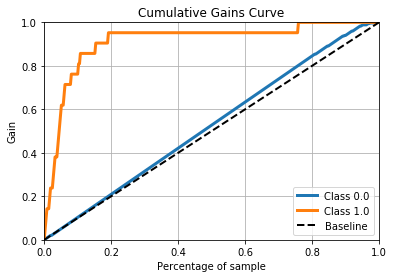

In [11]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt

nb = GaussianNB()
nb.fit(X_train2, y_train)
predicted_probas = nb.predict_proba(X_test2)

import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_test, predicted_probas)
plt.show()

The example above shows how much better the predictive model is at identifying HoF inductees compared to baseline. 
The model does not do that much better at identifying those who will not make the HoF, but this is fine since this is not within the scope of this project.

### Roc Curve

AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. 
ROC is a probability curve and AUC represents degree or measure of separability. 
It tells how much model is capable of distinguishing between classes. 
Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train/Test split results:
LogisticRegression accuracy is 0.968
LogisticRegression log_loss is 0.102
LogisticRegression auc is 0.973


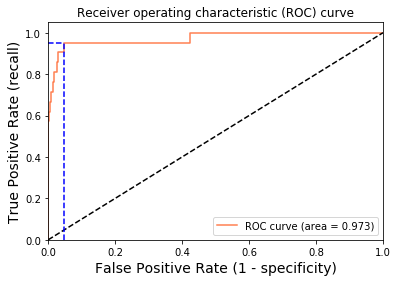

Using a threshold of 0.319 guarantees a sensitivity of 0.952 and a specificity of 0.954, i.e. a false positive rate of 4.58%.


In [12]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss


# use train/test split with different random_state values
# we can change the random_state values that changes the accuracy scores
# the scores change a lot, this is why testing scores is a high-variance estimate
# check classification scores of logistic regression
logreg = LogisticRegression()
logreg.fit(X_train2, y_train)
y_pred = logreg.predict(X_test2)
y_pred_proba = logreg.predict_proba(X_test2)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

### Confusion Matrix

A confusion matrix is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known. All the measures except AUC can be calculated by using left most four parameters. So, let’s talk about those four parameters first.

#### True Positives (TP) - 
These are the correctly predicted positive values which means that the value of actual class is yes and the value of predicted class is also yes. E.g. if actual class value indicates that this passenger survived and predicted class tells you the same thing.

#### True Negatives (TN) -
These are the correctly predicted negative values which means that the value of actual class is no and value of predicted class is also no. E.g. if actual class says this passenger did not survive and predicted class tells you the same thing.

False positives and false negatives, these values occur when your actual class contradicts with the predicted class.

#### False Positives (FP) – 
When actual class is no and predicted class is yes. E.g. if actual class says this passenger did not survive but predicted class tells you that this passenger will survive.

#### False Negatives (FN) – 
When actual class is yes but predicted class in no. E.g. if actual class value indicates that this passenger survived and predicted class tells you that passenger will die.

Text(0.5, 257.44, 'Predicted label')

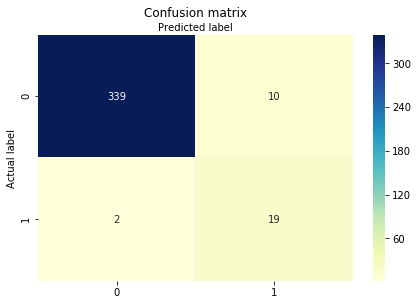

In [13]:
#confusion matrix
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

#### Use the describe() function to see what the 25th percentile is for a set of stats. This will be our 'threshold' to make the HoF (a player should reach the threshold in order to have a good change of making the HoF

Change the data type to conduct describe analysis

In [14]:
#tranforming the inducted column in each df to factor so only two colors are shown on specific plots
X['inducted'] = X['inducted'].astype(object)

In [15]:
dfP[dfP['inducted'] == 1][['awardCount', 'ERA']].describe()

,awardCount,ERA
count,71.000000,71.000000
mean,7.859155,2.997832
std,7.742823,0.441369
min,0.000000,1.815585
25%,2.000000,2.752964
50%,5.000000,3.055129
75%,11.000000,3.291379
max,33.000000,3.899843


A pitcher must win at least 2 awards and have an ERA under 3.29 to have a good chance of making HoF (need to look at 75th percentile for ERA since lower ERA is better)


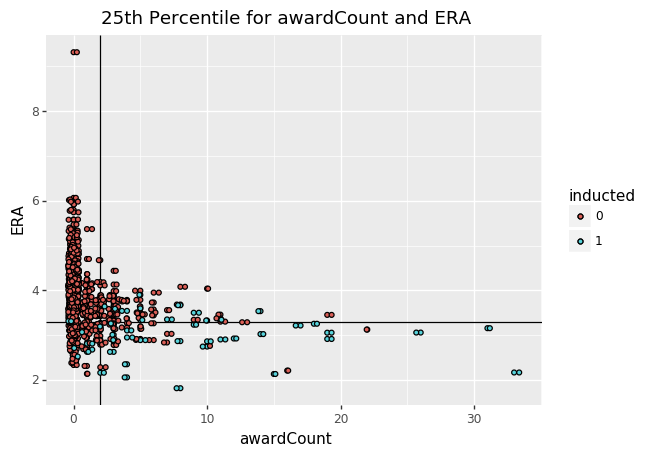

<ggplot: (-9223363290711700515)>

In [16]:
X['inducted'] = X['inducted'].astype(object)
ggplot(X, aes(x = 'awardCount', y = 'ERA', fill='inducted'))  \
+ geom_vline(xintercept=2) + geom_hline(yintercept=3.29) \
  + geom_point() + geom_jitter() + ggtitle("25th Percentile for awardCount and ERA")
#outline steroids in yellow


#use different dataframes to show viz's for each ()


Create coefficient plot to show which variables are weighted the highest and lowest for our model

### Coefficients Plot

This will show variable coeffieicients for each variable in our dfP model.The coefficient value represents the mean change in the response given a one-unit increase in the predictor. Consequently, it's easy to think that variables with larger coefficients are more important because they represent a larger change in the response.

In [17]:
results = sm.Logit(y_train, X_train2).fit(method = 'nm', maxiter=1000)


err_series = results.params - results.conf_int()[0]

coef_df = pd.DataFrame({'coef': results.params.values,
                        'err': err_series.values,
                        'varname': err_series.index.values
                       })

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


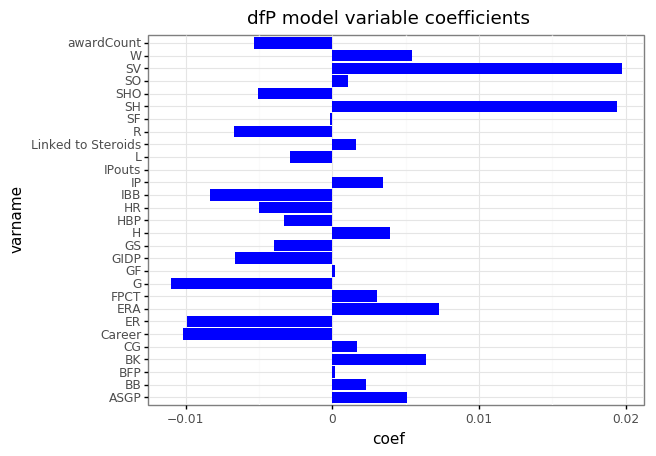

<ggplot: (-9223363290711700725)>

In [18]:
g1 = ggplot(coef_df, aes(x='varname', y='coef')) +  geom_bar(stat="identity", fill='blue',position=position_dodge(width=0.9),width=0.9) 
g1 +  coord_flip() + theme_bw() +  labs(title='dfP model variable coefficients')


In [19]:
nonEligibledfO = dfP[(dfP['HOFeligible'] == 0) & (dfP['Career'] > 9)]
dfP = dfP.replace([np.inf, -np.inf], np.nan)
dfP = dfP.fillna(0)

X_nonEligibledfO = nonEligibledfO[feature_cols]
y_pred = logreg.predict(X_nonEligibledfO)
nonEligibledfO.iloc[y_pred == 1]

,playerID,fullName,hof_perc,hof_proj,inducted,InnOuts,FPCT,ActiveFlag,Linked to Steroids,Career,...,ERA,BAOpp,K/9,BB/9,HR/9,K:BB,K%,BB%,I/GS,W%
5168,mccorji01,Jim McCormick,90.28,1.0,0.0,14127.0,0.915512,0,0,9.389041,...,2.431200,0.231160,3.586809,1.576596,0.172605,2.275033,0.096260,0.042312,8.815808,0.546392
5224,mcginjo01,Joe McGinnity,99.61,1.0,1.0,10506.0,0.919135,0,0,9.471233,...,2.657110,0.231814,2.793103,2.123596,0.135994,1.315271,0.075573,0.057458,9.032371,0.645669
8279,verlaju01,Justin Verlander,63.11,1.0,0.0,8277.0,0.929032,1,0,13.917808,...,3.389271,0.211352,8.827111,2.635738,0.887278,3.349010,0.238498,0.071215,6.584726,0.486874


In [20]:
#predict what currently non eligible players (who still played at least 9 years) will likely make the hall 
X_nonEligibledfO = nonEligibledfO[feature_cols]
y_pred = logreg.predict(X_nonEligibledfO)
nonEligibledfO.iloc[y_pred == 1] 

,playerID,fullName,hof_perc,hof_proj,inducted,InnOuts,FPCT,ActiveFlag,Linked to Steroids,Career,...,ERA,BAOpp,K/9,BB/9,HR/9,K:BB,K%,BB%,I/GS,W%
5168,mccorji01,Jim McCormick,90.28,1.0,0.0,14127.0,0.915512,0,0,9.389041,...,2.431200,0.231160,3.586809,1.576596,0.172605,2.275033,0.096260,0.042312,8.815808,0.546392
5224,mcginjo01,Joe McGinnity,99.61,1.0,1.0,10506.0,0.919135,0,0,9.471233,...,2.657110,0.231814,2.793103,2.123596,0.135994,1.315271,0.075573,0.057458,9.032371,0.645669
8279,verlaju01,Justin Verlander,63.11,1.0,0.0,8277.0,0.929032,1,0,13.917808,...,3.389271,0.211352,8.827111,2.635738,0.887278,3.349010,0.238498,0.071215,6.584726,0.486874


Need to go back and recreate dfP with debut column, or could merge the playerID with the finalGame column. 


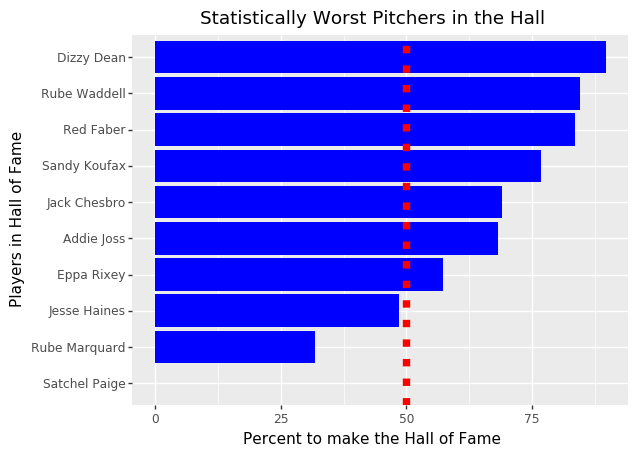

<ggplot: (8746141414043)>

In [21]:
bot_dfP = dfP[dfP.inducted == 1].sort_values(by='hof_perc', ascending=True).head(10)
bot_dfP_list = bot_dfP.sort_values(by='hof_perc', ascending=True)['fullName'].tolist()
bot_dfP_list
bot_dfP_cat = pd.CategoricalDtype(categories=bot_dfP_list, ordered=True)
bot_dfP['name_cat'] = bot_dfP['fullName'].astype(str).astype(bot_dfP_cat)

g1 = ggplot(bot_dfP, aes(x='name_cat', y='hof_perc'))  + geom_bar(stat='identity', fill='blue') + coord_flip()
g1 = g1 + ylab("Percent to make the Hall of Fame") + xlab("Players in Hall of Fame")
g1 = g1 + ggtitle("Statistically Worst Pitchers in the Hall")
g1 + geom_hline(yintercept = 50, linetype="dotted", color="red",size = 3)


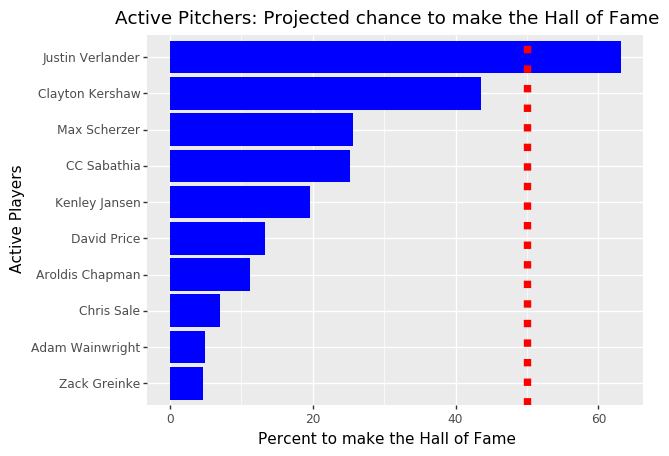

<ggplot: (8746143031318)>

In [22]:
People = pd.read_csv('~/jupyter/cs2019_Group4/data/core/People.csv')
People = People.drop(['birthYear', 'birthMonth', 'birthDay', 'birthCountry', 'birthState','birthCity','deathYear','deathMonth'], axis=1)
People = People.drop(['deathDay', 'deathCountry', 'deathState', 'deathCity', 'weight','height','bats','throws'], axis=1)
People = People.drop(['retroID', 'bbrefID'], axis=1)
People = People.drop(['nameFirst', 'nameLast', 'nameGiven','debut'], axis=1)
People['finalGame']= pd.to_datetime(People['finalGame'])
People['ActiveFlag'] = np.where((People['finalGame'].dt.year==datetime.datetime.now().year), 1, 0)#making boolean flag to indicate if a player is still playing
People = People[People['ActiveFlag'] ==1]
People.head()
dfPvisactive= People.merge(dfP, on='playerID', how='inner')
dfPvisactive.to_csv('dfPvalidator', index=False)
act_dfP = dfPvisactive.sort_values(by='hof_perc', ascending=False).head(10)
act_dfP_list = act_dfP.sort_values(by='hof_perc', ascending=True)['fullName'].tolist()
act_dfP_list
act_dfP_cat = pd.CategoricalDtype(categories=act_dfP_list, ordered=True)
act_dfP['name_cat'] = act_dfP['fullName'].astype(str).astype(act_dfP_cat)

g2 = ggplot(act_dfP, aes(x='name_cat', y='hof_perc'))  + geom_bar(stat='identity', fill='blue') + coord_flip()
g2 = g2 + ylab("Percent to make the Hall of Fame") + xlab("Active Players")
g2 = g2 + ggtitle("Active Pitchers: Projected chance to make the Hall of Fame")
g2 + geom_hline(yintercept = 50, linetype="dotted", color="red",size = 3)




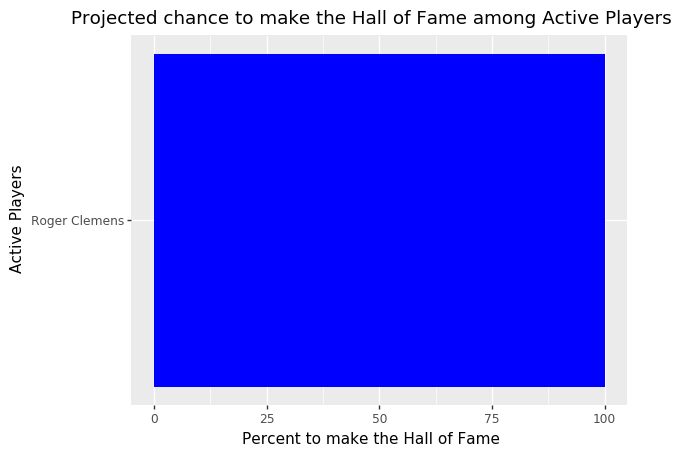

<ggplot: (8752858229950)>

In [26]:
hof = dfP[dfP.hof_proj == 1] 
act_dfP = hof[hof['Linked to Steroids'] == 1].sort_values(by='hof_perc', ascending=False).head(10)
act_dfP_list = act_dfP.sort_values(by='hof_perc', ascending=True)['fullName'].tolist()
act_dfP_list
act_dfP_cat = pd.CategoricalDtype(categories=act_dfP_list, ordered=True)
act_dfP['name_cat'] = act_dfP['fullName'].astype(str).astype(act_dfP_cat)

g2 = ggplot(act_dfP, aes(x='name_cat', y='hof_perc'))  + geom_bar(stat='identity', fill='blue') + coord_flip()
g2 = g2 + ylab("Percent to make the Hall of Fame") + xlab("Active Players")
g2 = g2 + ggtitle("Projected chance to make the Hall of Fame among Active Players")

g2